# **Predicci√≥n de promedio academico y nivel de estr√©s en estudiantes usando modelos de Machine Learning.**

**Di Paolo Lafalla, Victoria**  
victoria.dipaolo@mi.unc.edu.ar

**Salvatierra Costa, Baltazar Nicol√°s**  
salvatierra.baltazar@mi.unc.edu.ar  

**Facultad de Matem√°tica, Astronom√≠a, F√≠sica y Computaci√≥n (FAMAF)**  
**Universidad Nacional de C√≥rdoba**  
Av. Medina Allende y Haya de la Torre - Ciudad Universitaria  
X5016LAE - C√≥rdoba, Argentina


In [ ]:
import numpy as np
import kagglehub
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from mlxtend.plotting import plot_decision_regions
import statsmodels.api as sm

#---------Modelos---------#

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier,VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet

## **Introducci√≥n**

En este trabajo analizamos un dataset obtenido a partir de una encuesta realizada a 2000 estudiantes, en la que se consultaba sobre la cantidad de horas dedicadas a distintas actividades diarias, su nivel de estr√©s y su GPA (Grade Point Average). Una variable clave en este conjunto de datos es el nivel de estr√©s, que no fue directamente relevada, sino que fue calculada como una funci√≥n de las respuestas proporcionadas en la encuesta. El objetivo original del dataset, planteado por el creador del mismo, era predecir este nivel de estr√©s. \\

A partir de este punto de partida, nuestro enfoque fue explorar diferentes modelos y problemas asociados. Inicialmente, intentamos clasificar a los individuos seg√∫n si su GPA estaba por encima o por debajo del promedio. Luego, reorientamos el an√°lisis hacia una regresi√≥n para predecir el GPA de manera continua.
Adem√°s, retomamos el problema original de clasificar el nivel de estr√©s, donde obtuvimos muy buenos resultados, explicados por el car√°cter determin√≠stico de la variable objetivo. \\

 A lo largo del trabajo, probamos distintos modelos de clasificaci√≥n y regresi√≥n, y analizamos m√©tricas espec√≠ficas para cada uno, lo que nos permiti√≥ evaluar el rendimiento de manera adecuada en cada escenario. En todos los casos, la cantidad de horas de estudio emergi√≥ como la variable m√°s relevante dentro del modelo. \\

## **Estudio del dataset**

Este conjunto de datos, titulado "Estilo de vida diario y rendimiento acad√©mico de los estudiantes", contiene informaci√≥n de 2.000 estudiantes recopilada a trav√©s de una encuesta realizada con Google Forms. Incluye datos sobre horas de estudio, actividades extracurriculares, horas de sue√±o, vida social, actividad f√≠sica, niveles de estr√©s y GPA. La informaci√≥n abarca el a√±o acad√©mico desde agosto de 2023 hasta mayo de 2024 y refleja principalmente los estilos de vida de estudiantes en la India. Este conjunto de datos permite analizar el impacto de los h√°bitos diarios en el rendimiento acad√©mico y el bienestar estudiantil.

In [ ]:
# Descargamos el dataset
path = kagglehub.dataset_download("steve1215rogg/student-lifestyle-dataset")
print("Path to dataset files:", path)

# Vemos archivos disponibles
print("Archivos:", os.listdir(path))

# Cargamos el CSV en un DataFrame
df = pd.read_csv(os.path.join(path, "student_lifestyle_dataset.csv"))

Path to dataset files: /kaggle/input/student-lifestyle-dataset
Archivos: ['student_lifestyle_dataset.csv']


In [ ]:
data = df.copy()
data = df.drop(columns=['Student_ID'])

data.head()

Study_Hours_Per_Day  Extracurricular_Hours_Per_Day  Sleep_Hours_Per_Day  \
0                  6.9                            3.8                  8.7   
1                  5.3                            3.5                  8.0   
2                  5.1                            3.9                  9.2   
3                  6.5                            2.1                  7.2   
4                  8.1                            0.6                  6.5   

   Social_Hours_Per_Day  Physical_Activity_Hours_Per_Day   GPA Stress_Level  
0                   2.8                              1.8  2.99     Moderate  
1                   4.2                              3.0  2.75          Low  
2                   1.2                              4.6  2.67          Low  
3                   1.7                              6.5  2.88     Moderate  
4                   2.2                              6.6  3.51         High

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Study_Hours_Per_Day              2000 non-null   float64
 1   Extracurricular_Hours_Per_Day    2000 non-null   float64
 2   Sleep_Hours_Per_Day              2000 non-null   float64
 3   Social_Hours_Per_Day             2000 non-null   float64
 4   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 5   GPA                              2000 non-null   float64
 6   Stress_Level                     2000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 109.5+ KB


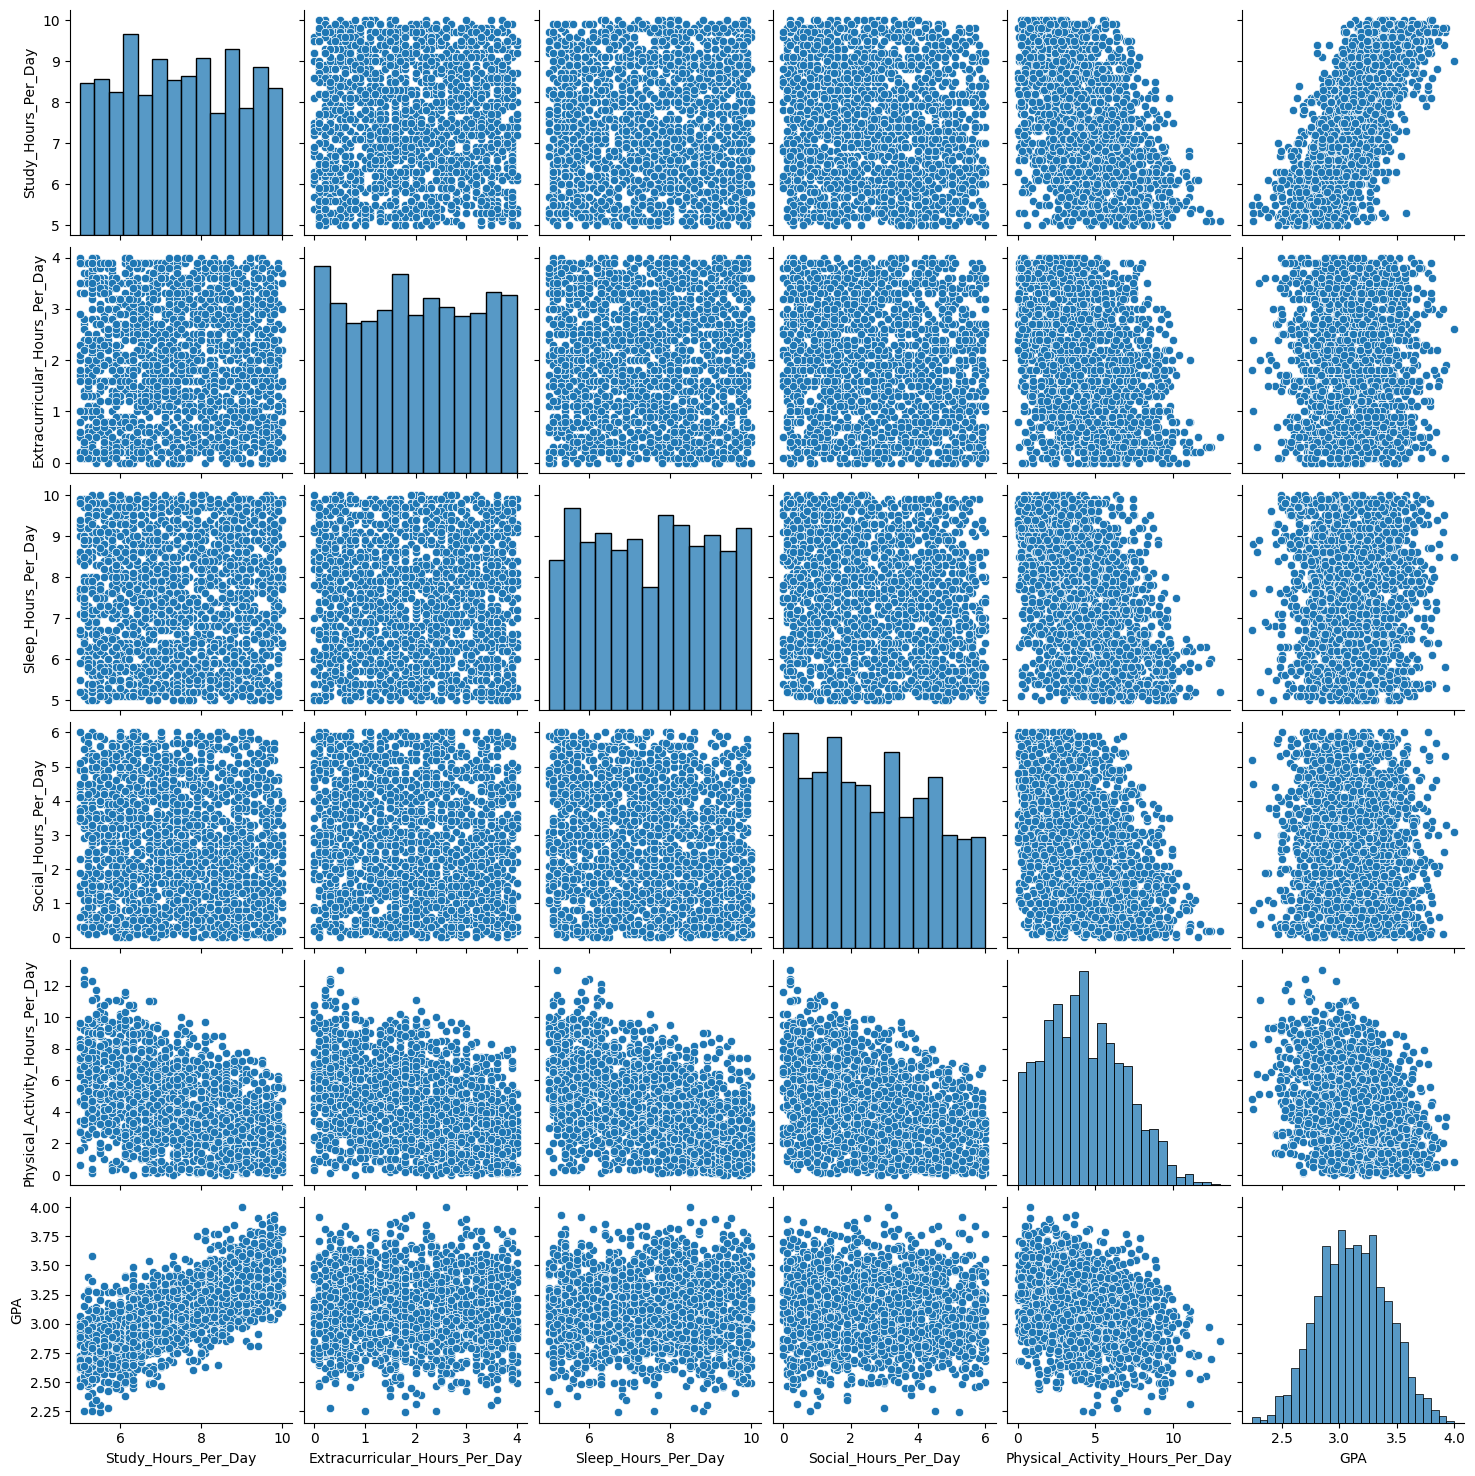

In [ ]:
#Hacemos un pairplot
sns.pairplot(data)

Del pairplot se puede observar la relaci√≥n aparente entre las horas de estudio diarias y el GPA, as√≠ como tambi√©n el comportamiento gaussiano del GPA.

## **Predicci√≥n de estudiantes por encima y por debajo del promedio**

### An√°lisis preliminar de los datos

Generamos una nueva columna de variable binaria, con valor "1" si el GPA de la persona est√° por encima del promedio o "0" si no lo est√°.

In [ ]:
gpa_mean = data['GPA'].mean()
print(f"Promedio de GPA: {gpa_mean:.2f}")

data['GPA_binary'] = (data['GPA'] > gpa_mean).astype(int)

print(data[['GPA', 'GPA_binary']].head())

# Tiramos la columna de GPA
data.drop(columns=['GPA'], inplace=True)

Promedio de GPA: 3.12
    GPA  GPA_binary
0  2.99           0
1  2.75           0
2  2.67           0
3  2.88           0
4  3.51           1


Vemos que las clases est√°n balanceadas.

In [ ]:
# Clases desbalanceadas? -> NO
data['GPA_binary'].value_counts()

GPA_binary
0    1016
1     984
Name: count, dtype: int64

Definimos nuestra variable target "GPA_binary".

In [ ]:
X=data.drop(columns=['GPA_binary'])
y=data['GPA_binary'] # Variable target
# Usamos stratify para tener el mismo desbalance de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Procesamos las variables categoicas con OneHotEncoder y las numericas con StandarScaler.

In [ ]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categ√≥ricas:", categorical_cols)
print("Num√©ricas:", numerical_cols)

Categ√≥ricas: ['Stress_Level']
Num√©ricas: ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day']


In [ ]:
# Preprocesadores
categorical_transformer = OneHotEncoder()
numerical_transformer = StandardScaler()

# ColumnTransformer aplica cada transformador a su tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ]
)

# Pipeline final
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])

#Fit y transform
preprocessor.fit(X_train)

# Obtenemos nombres de columnas transformadas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(cat_feature_names) + numerical_cols

# Aplicamos la transformaci√≥n
X_train_proc_array = preprocessor.transform(X_train)
X_test_proc_array = preprocessor.transform(X_test)

# Convertimos a DataFrame con nombres
X_train_proc = pd.DataFrame(X_train_proc_array, columns=all_feature_names, index=X_train.index)
X_test_proc = pd.DataFrame(X_test_proc_array, columns=all_feature_names, index=X_test.index)

### Predicci√≥n de alumnos por debajo y por encima del promedio

Comenzamos evaluando los siguientes modelos con tres conjuntos distintos de hiperaparemtros elegidos con el objetivo de abarcar un amplio rango de posibilidades. La idea es ver como cambia la eficiencia de cada modelo al variar los mismos.

Usamos: Logistic Regression, Linear Discriminant Analysis, Support Vector Machine, K Nearest Neighbours, Random Forest y XGBoost.


In [ ]:
param_grids = {
    'Logistic Regression': [
        {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'},
        {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'},
        {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
    ],
    'LDA': [
        {'solver': 'svd', 'shrinkage': None},
        {'solver': 'lsqr', 'shrinkage': None},
        {'solver': 'lsqr', 'shrinkage': 'auto'}
    ],
    'SVM': [
        {'C': 1.0, 'kernel': 'rbf'},
        {'C': 0.1, 'kernel': 'linear'},
        {'C': 10, 'kernel': 'rbf'}
    ],
    'KNN': [
        {'n_neighbors': 5, 'weights': 'uniform', 'p': 2},
        {'n_neighbors': 7, 'weights': 'distance', 'p': 2},
        {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}
    ],
    'Random Forest': [
        {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'},
        {'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt'},
        {'n_estimators': 100, 'max_depth': 5, 'max_features': 'log2'}
    ],
    'XGBoost': [
        {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
        {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05},
        {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}
    ]
}

model_classes = {
    'Logistic Regression': LogisticRegression,
    'LDA': LinearDiscriminantAnalysis,
    'SVM': SVC,
    'KNN': KNeighborsClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

resultados = []

for model_name, param_list in param_grids.items():
    ModelClass = model_classes[model_name]
    for params in param_list:
        if model_name == 'LDA' and params.get('shrinkage') is None:
            model = ModelClass(solver=params['solver'])
        else:
            model = ModelClass(**params)

        if model_name == 'Logistic Regression':
            model.set_params(max_iter=1000)

        model.fit(X_train_proc, y_train)
        y_pred = model.predict(X_test_proc)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        resultados.append({
            'Modelo': model_name,
            'Hiperpar√°metros': str(params),
            'Accuracy': round(acc, 4),
            'F1 Score': round(f1, 4)
        })

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(['Modelo', 'Accuracy'], ascending=[True, False])

# Mostramos tabla en consola con formato bonito
print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Modelo              ‚îÇ Hiperpar√°metros                                                  ‚îÇ   Accuracy ‚îÇ   F1 Score ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ KNN                 ‚îÇ {'n_neighbors': 7, 'weights': 'distance', 'p': 2}                ‚îÇ     0.7375 ‚îÇ     0.723  ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

Vemos que Logistic Regression y LDA son estables ante el cambio el hiperparametros y dan buen rendimiento. Es por esto que los usaremos como baseline para comparar con otros posibles modelos.

Siendo que Random Forest, SVM y XGBoost tienen variaci√≥n en sus resultados y no alcanzan a ser los mejores modelos, haremos un Grid Search para ajustar los mejores hiperparametros en cada caso.

Adem√°s, descartamos el modelo de KNN debido a su bajo rendimiento.

In [ ]:
# Definimos los hiperpar√°metros a probar para cada modelo
param_grids = {
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 1, 2, 3, 5],
        'max_features': ['sqrt', 'log2', None],
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
}
# Modelos
models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

resultados = []

for model_name in models:
    grid = GridSearchCV(models[model_name], param_grids[model_name], cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    grid.fit(X_train_proc, y_train)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_proc)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        'Modelo': model_name,
        'Mejores Hiperpar√°metros': grid.best_params_,
        'Accuracy': acc,
        'F1 Score': f1
    })

df_resultados = pd.DataFrame(resultados)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Modelo        ‚îÇ Mejores Hiperpar√°metros                                       ‚îÇ   Accuracy ‚îÇ   F1 Score ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ SVM           ‚îÇ {'C': 10, 'gamma': 0.01, 'kern

Es llamativo que los modelos complejos, incluso luego de realizar una b√∫squeda exhaustiva de sus mejores hiperpar√°metros, sigan sin superar el rendimiento del baseline. Dado este comportamiento, continuamos el an√°lisis con los modelos de base.

Planteamos la hip√≥tesis de que estamos ante un problema simple, con una relaci√≥n esencialmente lineal o dominado por una √∫nica variable altamente predictiva. Esto explicar√≠a por qu√© los modelos complejos no mejoran su desempe√±o: tienden a buscar patrones no lineales en un problema donde probablemente no los hay, lo que puede inducir sobreajuste o a√±adir complejidad innecesaria.

In [ ]:
#Definimos una funci√≥n para ver la importancia de cada variable en el modelo

def plot_permutation_importance(model, X_test, y_test, feature_names):
    importances = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_indices = importances.importances_mean.argsort()

    plt.figure(figsize=(6, 4))
    plt.barh(range(len(sorted_indices)), importances.importances_mean[sorted_indices], color="skyblue")
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.xlabel("Importancia de la variable")
    plt.title(f"Importancia de cada variable haciendo uso del modelo {model}")
    plt.show()

La **permutation importance** mide cu√°nto empeora la performance del modelo (por ejemplo, accuracy) cuando se desordena aleatoriamente una variable.

Si al permutar una variable, la performance baja mucho ‚Üí esa variable es importante.

Si al permutar una variable, la performance casi no cambia ‚Üí esa variable no es relevante.



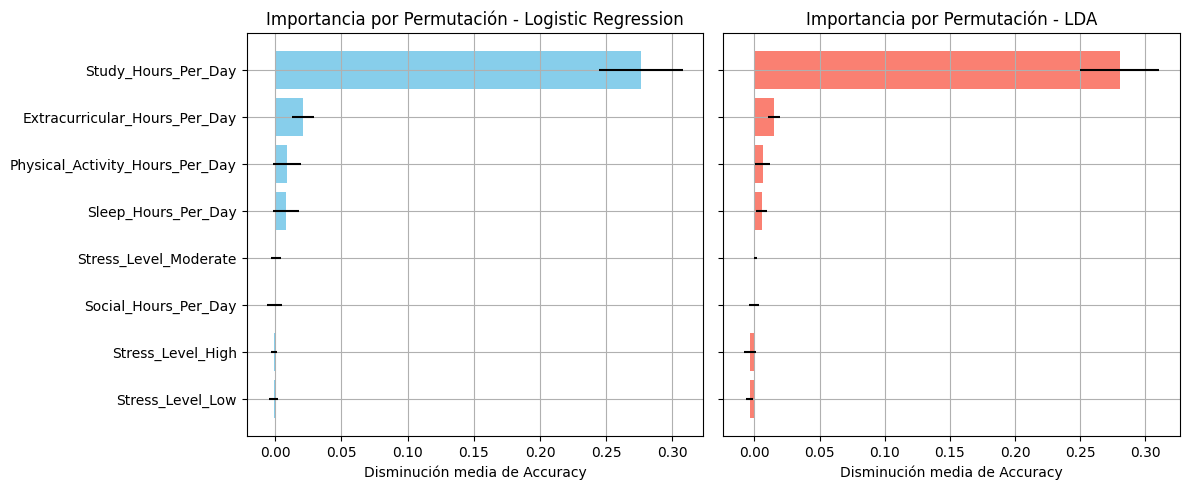

In [ ]:
feature_names = all_feature_names

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_proc, y_train)

# LDA
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_proc, y_train)

# Calculo importancias por permutaci√≥n para Logistic Regression
lr_result = permutation_importance(lr_model, X_test_proc, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Calculo importancias por permutaci√≥n para LDA
lda_result = permutation_importance(lda_model, X_test_proc, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Ordenamos las features por importancia para graficar prolijo
lr_sorted_idx = lr_result.importances_mean.argsort()
lda_sorted_idx = lda_result.importances_mean.argsort()

sorted_idx = lr_result.importances_mean.argsort()
sorted_features = np.array(feature_names)[sorted_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression
axes[0].barh(np.array(feature_names)[lr_sorted_idx], lr_result.importances_mean[lr_sorted_idx],
              xerr=lr_result.importances_std[lr_sorted_idx], color='skyblue')
axes[0].set_title('Importancia por Permutaci√≥n - Logistic Regression')
axes[0].set_xlabel('Disminuci√≥n media de Accuracy')
axes[0].grid()

# LDA
axes[1].barh(np.array(feature_names)[lda_sorted_idx], lda_result.importances_mean[lda_sorted_idx],
              xerr=lda_result.importances_std[lda_sorted_idx], color='salmon')
axes[1].set_title('Importancia por Permutaci√≥n - LDA')
axes[1].set_xlabel('Disminuci√≥n media de Accuracy')
axes[1].set_yticks(np.arange(len(sorted_features)))
axes[1].set_yticklabels(['' for _ in sorted_features])
axes[1].grid()

plt.tight_layout()
plt.show()

Intenemos hacer una clasificaci√≥n solamente usando Study Hours per Day.

In [ ]:
X=data[['Study_Hours_Per_Day']]
y=data['GPA_binary'] #Variable target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Lista para guardar resultados
resultados = []

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=1, penalty="l2", solver="lbfgs")
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

resultados.append({
    'Modelo': 'Logistic Regression',
    'Accuracy': round(acc_lr, 4),
    'F1 Score': round(f1_lr, 4)
})

# LDA
lda_model = LinearDiscriminantAnalysis(solver='svd')
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)

acc_lda = accuracy_score(y_test, y_pred_lda)
f1_lda = f1_score(y_test, y_pred_lda)

resultados.append({
    'Modelo': 'LDA',
    'Accuracy': round(acc_lda, 4),
    'F1 Score': round(f1_lda, 4)
})


df_resultados = pd.DataFrame(resultados)
print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Modelo              ‚îÇ   Accuracy ‚îÇ   F1 Score ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Logistic Regression ‚îÇ       0.77 ‚îÇ     0.7653 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ LDA                 ‚îÇ       0.77 ‚îÇ     0.7653 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ


Sabiendo que cuando solo ten√©s una √∫nica variable predictora, la f√≥rmula de la probabilidad en LDA y Logistic Regression se vuelve equivalente. Graficamos la curva ROC, la distribuci√≥n de probablidad y la matriz de confusi√≥n para LDA.

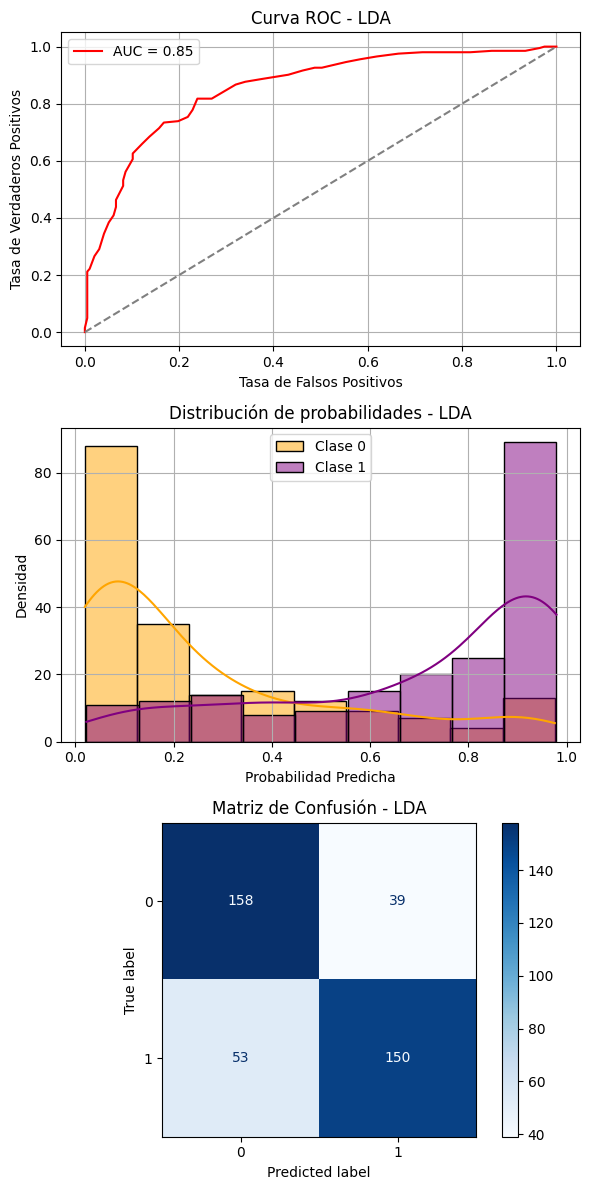

In [ ]:
# Predicciones y probabilidades
y_pred_lda = lda_model.predict(X_test)
y_proba_lda = lda_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# Curva ROC
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_proba_lda)
axes[0].plot(fpr_lda, tpr_lda, label=f'AUC = {roc_auc_score(y_test, y_proba_lda):.2f}', color='red')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel('Tasa de Falsos Positivos')
axes[0].set_ylabel('Tasa de Verdaderos Positivos')
axes[0].set_title('Curva ROC - LDA')
axes[0].legend()
axes[0].grid()

# Distribuci√≥n de probabilidades
sns.histplot(y_proba_lda[y_test == 0], color='orange', label='Clase 0', kde=True, ax=axes[1], alpha=0.5)
sns.histplot(y_proba_lda[y_test == 1], color='purple', label='Clase 1', kde=True, ax=axes[1], alpha=0.5)
axes[1].set_xlabel('Probabilidad Predicha')
axes[1].set_ylabel('Densidad')
axes[1].set_title('Distribuci√≥n de probabilidades - LDA')
axes[1].legend()
axes[1].grid()

# Matriz de Confusi√≥n
ConfusionMatrixDisplay.from_estimator(lda_model, X_test, y_test, cmap='Blues', ax=axes[2])
axes[2].set_title('Matriz de Confusi√≥n - LDA')

plt.tight_layout()
plt.show()


A forma de ilustraci√≥n, graficamos el umbral para el cual estos modelos deciden si pertenece a una clase o la otra.

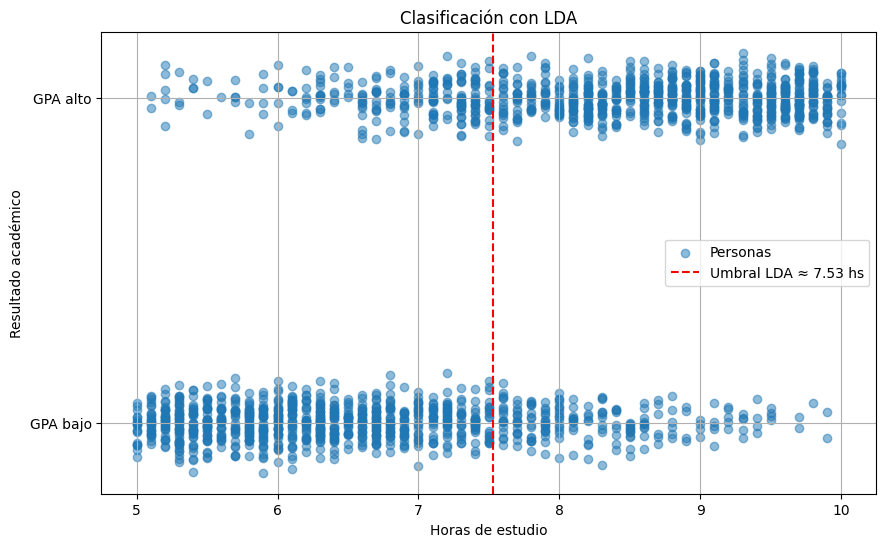

In [ ]:
w0 = lda_model.intercept_[0]
w1 = lda_model.coef_[0][0]
umbral = -w0 / w1

# Agregar jitter a y para mejorar la visualizaci√≥n
jitter = 0.05 * np.random.randn(len(y))
y_jittered = y + jitter

plt.figure(figsize=(10, 6))
plt.scatter(X, y_jittered, alpha=0.5, label='Personas')
plt.axvline(umbral, color='red', linestyle='--', label=f'Umbral LDA ‚âà {umbral:.2f} hs')
plt.yticks([0, 1], ['GPA bajo', 'GPA alto'])
plt.xlabel('Horas de estudio')
plt.ylabel('Resultado acad√©mico')
plt.title('Clasificaci√≥n con LDA')
plt.legend()
plt.grid(True)
plt.show()

### An√°lisis de resultados de la predicci√≥n de estudiantes por encima y por debajo del promedio

Inicialmente probamos distintos modelos, cada uno con tres configuraciones de hiperpar√°metros. A partir de esos resultados, establecimos como baseline los modelos de LDA y Logistic Regression, ya que no solo obtuvieron el mejor rendimiento, sino que tambi√©n demostraron mayor robustez frente a cambios en los hiperpar√°metros.

Luego, intentamos mejorar el rendimiento de modelos m√°s complejos como SVM, Random Forest y XGBoost, aplicando una b√∫squeda con grid search sobre un rango amplio de hiperpar√°metros. Sin embargo, no se observ√≥ ninguna mejora significativa.

Este comportamiento sugiere que la frontera de decisi√≥n que separa las clases es aproximadamente lineal. En consecuencia, aplicar modelos no lineales con kernels o estructuras m√°s complejas puede resultar en sobreajuste o simplemente a√±adir complejidad donde no se necesita.

Para verificar esta hip√≥tesis, utilizamos la funci√≥n permutation_importance, que indic√≥ que la variable horas de estudio tiene un peso predictivo significativamente mayor que el resto. Al eliminar todas las dem√°s variables y entrenar nuevamente los modelos de base, observamos que el rendimiento se manten√≠a pr√°cticamente igual.

Adem√°s, al evaluar el modelo utilizando la curva ROC, obtuvimos un AUC de 0.85, lo cual indica una excelente capacidad discriminativa incluso con una sola variable predictora. La matriz de confusi√≥n mostr√≥ que el modelo predice de manera equilibrada ambas clases (0 y 1), sin evidenciar un sesgo sistem√°tico hacia ninguna de ellas.

Esto nos lleva a concluir que el problema puede ser clasificado con eficiencia cercana al baseline utilizando una √∫nica variable predictora, y que la simplicidad del modelo est√° en l√≠nea con la estructura real y subyacente del problema.

## **Regresi√≥n para la predicci√≥n directa del promedio del alumno**

### An√°lisis preliminar de los datos

In [ ]:
data_reg = df.copy()

X = data_reg.drop(columns=["GPA", "Student_ID"])
y = data_reg["GPA"]

# One-hot encoder para 'Stress_Level'
ohe = OneHotEncoder(drop=None)
X_encoded = ohe.fit_transform(X[["Stress_Level"]])
encoded_cols = ohe.get_feature_names_out(["Stress_Level"])
encoded_data = X_encoded.toarray()
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols)

#Saco la columna anterior y pongo las del ohe
X = pd.concat([X.drop(columns=["Stress_Level"]), encoded_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

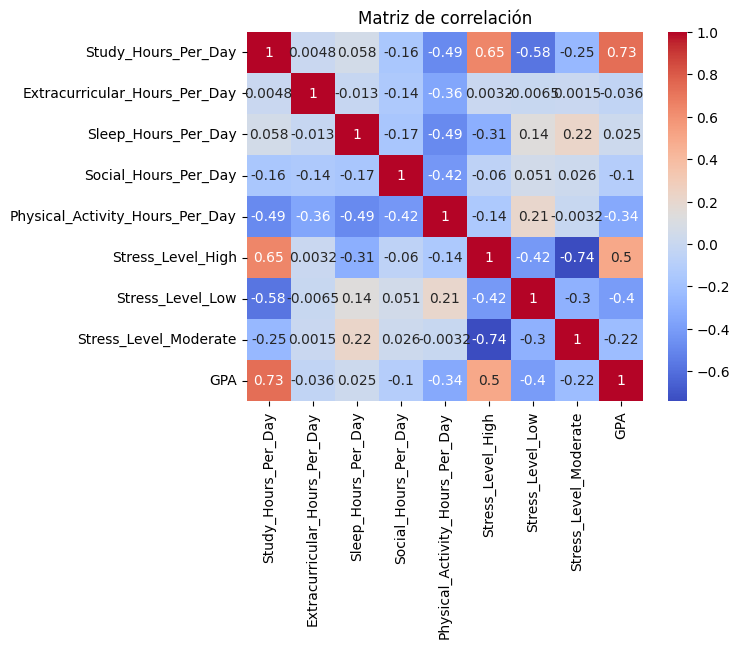

In [ ]:
data_reg = pd.concat([X_train, y_train], axis=1)
corr_matrix = data_reg.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlaci√≥n')
plt.show()

Analizando la matriz de correlaci√≥n, se identifican como variables relevantes para predecir el GPA la cantidad de horas de estudio y el nivel de estr√©s. Sin embargo, dado que el nivel de estr√©s es una variable determin√≠stica (calculada a partir de otras variables), decidimos excluirla del modelo de regresi√≥n para evitar redundancias, quedando √∫nicamente las horas de estudio como variable predictora.

Este resultado esta en linea con lo visto con la funci√≥n de importancia, verificando que la unica variable significativamente correlacionada con el GPA son las horas de estudio.

Graficamos el GPA en funci√≥n de las horas de estudio. A modo de ilustraci√≥n discriminamos con distintos colores el nivel de estr√©s de los estudiantes.

In [ ]:
data_reg1=df.copy()

X = data_reg1.drop(columns=["GPA", "Student_ID"])
y = data_reg1["GPA"]

X= X[["Study_Hours_Per_Day"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: xlabel='Study_Hours_Per_Day', ylabel='GPA'>

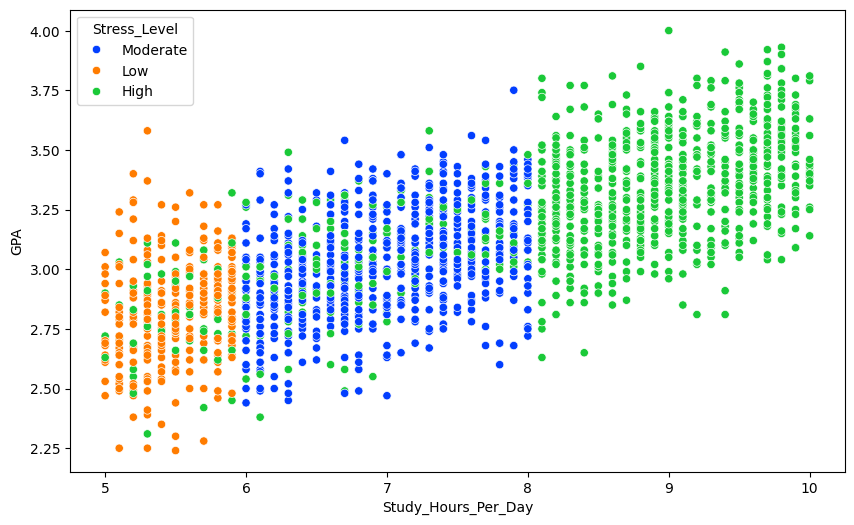

In [ ]:
#Grafico GPA en termino de Study Hours con un hue de stress
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_reg1, x='Study_Hours_Per_Day', y='GPA', hue='Stress_Level', palette='bright')

En el grafico se ve claramente una tendencia lineal entre el GPA y las horas de estudio, y una tendencia ascendente con el nivel de estr√©s.

###Predicci√≥n del GPA como variable cont√≠nua

Comenzamos evaluando los siguientes modelos con distintos de hiperaparemtros elegidos aleatoriamente. La idea es ver como cambia la eficiencia de cada modelo al variar los mismos.

Usamos: Linear Regression, Ridge, Lasso y ElasticNet.

In [ ]:
# Lista de modelos con hiperpar√°metros fijos
models = [
    LinearRegression(),
    Ridge(alpha=0.001),
    Lasso(alpha=0.1),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
]

resultados = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados.append({
        'Modelo': model.__class__.__name__,
        'MAE': mae,
        'R¬≤': r2
    })

# Convertimos a DataFrame y ordenamos por R¬≤ descendente
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='R¬≤', ascending=False).reset_index(drop=True)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Modelo           ‚îÇ      MAE ‚îÇ       R¬≤ ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ LinearRegression ‚îÇ 0.164412 ‚îÇ 0.550098 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Ridge            ‚îÇ 0.164412 ‚îÇ 0.550098 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ ElasticNet       ‚îÇ 0.169214 ‚îÇ 0.528327 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Lasso            ‚îÇ 0.177247 ‚îÇ 0.487134 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚

Debido a que todos tienen rendimientos similares, vamos a realizar un Grid Search para ver si mejor el desempe√±o de los regresores.

In [ ]:
# Definimos los modelos y sus grids
param_grids = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.001, 0.1, 1, 10]}
    },
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    },
    'ElasticNet': {
        'model': ElasticNet(max_iter=10000),
        'params': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
    },
}

resultados = []

# Evaluamos Linear Regression sin hiperpar√°metros
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

resultados.append({
    'Modelo': 'LinearRegression',
    'Mejores Par√°metros': 'Default',
    'MAE': mae,
    'R¬≤': r2
})

# Grid Search para los otros modelos
for name, config in param_grids.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    resultados.append({
        'Modelo': name,
        'Mejores Par√°metros': str(best_params),
        'MAE': mae,
        'R¬≤': r2
    })

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='R¬≤', ascending=False).reset_index(drop=True)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))


‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Modelo           ‚îÇ Mejores Par√°metros                ‚îÇ      MAE ‚îÇ       R¬≤ ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ LinearRegression ‚îÇ Default                           ‚îÇ 0.164412 ‚îÇ 0.550098 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Ridge            ‚îÇ {'alpha': 1}                      ‚îÇ 0.164417 ‚îÇ 0.550091 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

Dado que Ridge, Lasso y ElasticNet son extensiones del modelo de regresi√≥n lineal con regularizaci√≥n, es esperable que, tras una b√∫squeda de hiperpar√°metros, todos tiendan a un comportamiento similar, en este caso al de Linear Regression (cuando la penalizaci√≥n √≥ptima es cercana a cero). Esto ocurre cuando la regularizaci√≥n no aporta mejoras significativas al modelo. En estos casos, la soluci√≥n √≥ptima de los modelos regularizados converge a la soluci√≥n de m√≠nimos cuadrados ordinarios, explicando por qu√© el desempe√±o final es comparable al del modelo de regresi√≥n lineal simple.

El modelo obtenido presenta un coeficiente de determinaci√≥n 0.55, lo cual indica que aproximadamente el 55% de la variabilidad en el GPA es explicada por la variable horas de estudio.

Viendo que haciendo Grid Search el desempe√±o de los regresores es muy similar entre ellos, por lo que nos quedamos con 'Linear Regressor' por su simplicidad y bajo costo computacional.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


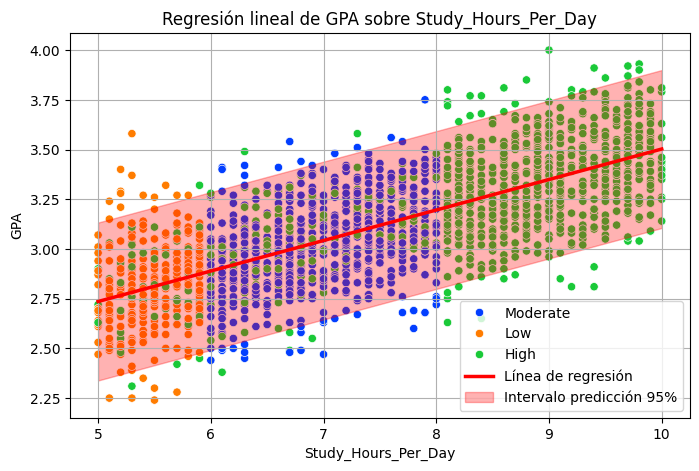

In [ ]:
# Entrenamos el modelo lineal
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_train_pred = model_linear.predict(X_train)

plt.figure(figsize=(8, 5))

# Graficamos los datos reales con hue por Stress_Level
sns.scatterplot(data=data_reg1, x='Study_Hours_Per_Day', y='GPA', hue='Stress_Level', palette='bright')

X_plot = np.linspace(X_train['Study_Hours_Per_Day'].min(), X_train['Study_Hours_Per_Day'].max(), 100)
X_plot_reshaped = X_plot.reshape(-1, 1)

# Predicci√≥n de la l√≠nea de regresi√≥n
y_plot = model_linear.predict(X_plot_reshaped)

# Ajustamos modelo statsmodels para intervalo de confianza y predicci√≥n
X_sm = sm.add_constant(X_train['Study_Hours_Per_Day'])
model_sm = sm.OLS(y_train, X_sm).fit()

X_plot_sm = sm.add_constant(X_plot)
preds = model_sm.get_prediction(X_plot_sm)
pred_summary = preds.summary_frame(alpha=0.05)

# Graficamos l√≠nea de regresi√≥n
plt.plot(X_plot, y_plot, color="red", label="L√≠nea de regresi√≥n", lw=2.5)

# Graficamos el intervalo de predicci√≥n para nuevas observaciones
plt.fill_between(X_plot, pred_summary['obs_ci_lower'], pred_summary['obs_ci_upper'], color='red', alpha=0.3, label='Intervalo predicci√≥n 95%')

plt.xlabel('Study_Hours_Per_Day')
plt.ylabel("GPA")
plt.title(f"Regresi√≥n lineal de GPA sobre Study_Hours_Per_Day")
plt.legend()
plt.grid(True)
plt.show()


###An√°lisis de resultados de la regresi√≥n del GPA

Se utiliz√≥ como unica variable predictora la cantidad de horas de estudio diarias. \\

Una vez realizada la regresi√≥n, se visualiz√≥ la distribuci√≥n de los puntos seg√∫n el nivel de estr√©s. Se observa que los puntos correspondientes a niveles de estr√©s bajo y moderado se encuentran en zonas de notas moderadas y bajas, muy pr√≥ximos, sin mezclarse, delimitados por un umbral claro que separa ambas categor√≠as. Por otro lado, los casos con nivel de estr√©s alto predominan en la zona de notas altas, tambi√©n mostrando un umbral bien definido; sin embargo, existe una dispersi√≥n homog√©nea de puntos con estr√©s alto a lo largo de todo el rango de datos. \\

El modelo obtenido presenta un coeficiente de determinaci√≥n R¬≤ = 0.55, lo cual indica que aproximadamente el 55% de la variabilidad en el GPA es explicada por la variable "horas de estudio por d√≠a". Este resultado es especialmente relevante considerando que el modelo utiliza √∫nicamente una caracter√≠stica predictora.

En problemas del √°mbito educativo, social o conductual, es habitual encontrar m√∫ltiples factores que influyen sobre la variable objetivo, muchos de los cuales no se encuentran disponibles o no son observables (por ejemplo, motivaci√≥n personal, calidad del estudio, contexto familiar, estado emocional, entre otros). Por esta raz√≥n, alcanzar valores de R¬≤ cercanos a 1 en estos contextos es poco frecuente y, en cambio, valores en el rango de 0.4 a 0.6 suelen ser considerados buenos indicadores de capacidad predictiva cuando se trabaja con modelos simples o con pocas variables (Gelman & Hill, 2007; Cohen et al., 2003).

En este caso particular, el hecho de que con una sola variable explicativa se logre un R¬≤ de 0.55 sugiere que las horas de estudio por d√≠a tienen un impacto fuerte y directo sobre el GPA, capturando gran parte de la tendencia del fen√≥meno. Este valor refleja que el modelo no solo es adecuado para explicar la relaci√≥n entre las variables, sino que tambi√©n proporciona una herramienta predictiva √∫til y con una interpretaci√≥n sencilla.

En resumen, el R¬≤ obtenido es satisfactorio para el tipo de problema abordado y para la simplicidad del modelo empleado.


## **Predicci√≥n de el nivel de estr√©s de los estudiantes**

### An√°lisis preeliminar de los datos

Comenzamos preparando el dataset haciendo un an√°lisis similar a cuando calculamos el GPA solo que cambiando la variable objetivo.

In [ ]:
data_stress=df.copy()

X=data_stress.drop(columns=['Stress_Level'])
y=data_stress['Stress_Level'] #Variable target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [ ]:
#Como solo tenemos variables numericas en el X_train, estandarizamos
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

X_train_stress = numeric_transformer.fit_transform(X_train)
X_test_stress = numeric_transformer.transform(X_test)

###Predicci√≥n de nivel de estr√©s

Inicialmente probamos la eficiencia de los mismos modelos que usamos a la hora de clasificar estudiantes por encima y por debajo del promedio.

In [ ]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "LDA": LinearDiscriminantAnalysis(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

results_stress = []

for name, model in classifiers.items():
    model.fit(X_train_stress, y_train)
    y_pred = model.predict(X_test_stress)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results_stress.append((name, acc, f1))

results_stress = pd.DataFrame(results_stress, columns=['Modelo', 'Accuracy', 'F1 Score'])
results_stress = results_stress.sort_values(by='F1 Score', ascending=False)

print("\nüìä Comparaci√≥n de modelos:")
print(tabulate(results_stress, headers='keys', tablefmt='fancy_grid', showindex=False))


üìä Comparaci√≥n de modelos:
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Modelo              ‚îÇ   Accuracy ‚îÇ   F1 Score ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Random Forest       ‚îÇ     1      ‚îÇ   1        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Gradient Boosting   ‚îÇ     1      ‚îÇ   1        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ AdaBoost            ‚îÇ     0.965  ‚îÇ   0.966266 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

### An√°lisis de los resultados de la predicci√≥n de nivel de estr√©s

Para clasificaci√≥n del nivel de estr√©s, categorizado en bajo, moderado y alto, se obtuvieron resultados de accuracy igual a 1 para los m√©todos adaptativos, mientras que para LDA alcanz√≥ 0,77. Este comportamiento es esperable dado que el nivel de estr√©s en el dataset (obtenido a partir de una encuesta) fue calculado como una funci√≥n de las propias respuestas proporcionadas por los participantes, lo que introduce un car√°cter determin√≠stico en la variable objetivo. \\

El hecho de que LDA no logre un rendimiento perfecto puede atribuirse a que la relaci√≥n entre las respuestas de la encuesta y el nivel de estr√©s no es estrictamente lineal, lo cual limita la capacidad de este m√©todo lineal para separar las clases de manera exacta. En cambio, los m√©todos adaptativos, al ser m√°s flexibles, logran capturar con mayor precisi√≥n la estructura subyacente en los datos.


Los resultados obtenidos al aplicar los modelos entrenados al dataset de la encuesta realizada en FAMAF evidencian un bajo desempe√±o predictivo. En particular, el modelo tiende a subestimar las notas de los estudiantes, lo que sugiere que las horas de estudio no explican con precisi√≥n el rendimiento acad√©mico en esta muestra.

Adem√°s, la f√≥rmula utilizada para calcular el nivel de estr√©s en el dataset original no ajusta correctamente a los datos relevados en FAMAF. Esto puede deberse tanto a limitaciones en la formulaci√≥n original como a la subjetividad del estr√©s autopercibido en la nueva encuesta.

Estas diferencias de desempe√±o son esperables, dado que el dataset FAMAF no pertenece al conjunto original y no conocemos con detalle el criterio de recolecci√≥n de los datos de origen. El modelo original fue entrenado en un contexto espec√≠fico y bajo definiciones particulares de las variables, mientras que en la encuesta propia el nivel de estr√©s fue autopercibido, introduciendo variabilidad no considerada previamente.

En conclusi√≥n, el bajo rendimiento de los modelos sobre el nuevo conjunto de datos resalta la importancia de adaptar y validar los modelos para cada contexto particular, especialmente cuando las variables clave cambian en su definici√≥n o forma de medici√≥n.

##**Conclusi√≥n**

Este trabajo abord√≥ cuatro ejes principales vinculados a la predicci√≥n del rendimiento acad√©mico y el nivel de estr√©s en estudiantes, a partir de datos de encuestas estructuradas.

1. Clasificaci√≥n de estudiantes por rendimiento

  Se compararon modelos de clasificaci√≥n para predecir si un estudiante se encuentra por encima o por debajo del promedio acad√©mico. Logistic Regression y LDA resultaron ser los modelos m√°s eficaces, superando a m√©todos m√°s complejos como SVM, Random Forest y XGBoost, incluso tras aplicar b√∫squeda de hiperpar√°metros. La simplicidad del problema, dominado por una √∫nica variable predictora fuerte, justific√≥ el buen desempe√±o de modelos lineales. El modelo mostr√≥ un AUC de 0.85 y una predicci√≥n equilibrada entre clases.

2. Regresi√≥n para predecir el GPA

  Se construy√≥ un modelo de regresi√≥n lineal utilizando √∫nicamente la variable ‚Äúhoras de estudio por d√≠a‚Äù, excluyendo el nivel de estr√©s por su naturaleza determin√≠stica. Se obtuvo un coeficiente de determinaci√≥n R¬≤ = 0.55, un valor satisfactorio para un modelo univariado en un contexto educativo, lo que sugiere un impacto fuerte y directo de esa variable sobre el GPA.

3. Clasificaci√≥n del nivel de estr√©s

  Se evalu√≥ la predicci√≥n del nivel de estr√©s (bajo, moderado, alto), observ√°ndose un accuracy perfecto en modelos como XGBoost, dada la naturaleza de esta variable en el dataset original (calculada a partir de otras variables). LDA, al ser un modelo lineal, alcanz√≥ un desempe√±o menor (accuracy = 0.77) lo cual sugiere que la ecuaci√≥n utilizada para el c√°lculo del nivel de estr√©s es de caracter no lineal.

En conjunto, este trabajo explor√≥ la relaci√≥n entre las horas de estudio, el rendimiento acad√©mico y el nivel de estr√©s en estudiantes, comparando distintos enfoques de clasificaci√≥n y regresi√≥n.